## Imports

In [1]:
!pip install awswrangler

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

## DF Upload

In [3]:
df = pd.read_csv(r'1st_adyen_rides-success-and-fail.csv')

## DF Discovery

In [4]:
df.shape

(304053, 22)

In [5]:
df.dtypes

created                   object
device_name               object
device_os_version         object
country                   object
city_id                  float64
lat                      float64
lng                      float64
real_destination_lat     float64
real_destination_lng     float64
user_id                    int64
order_id                   int64
order_try_id               int64
distance                   int64
ride_distance              int64
price                    float64
ride_price               float64
price_review_status       object
price_review_reason       object
is_successful_payment      int64
name                      object
card_bin                 float64
failed_attempts            int64
dtype: object

In [6]:
df.columns

Index(['created', 'device_name', 'device_os_version', 'country', 'city_id',
       'lat', 'lng', 'real_destination_lat', 'real_destination_lng', 'user_id',
       'order_id', 'order_try_id', 'distance', 'ride_distance', 'price',
       'ride_price', 'price_review_status', 'price_review_reason',
       'is_successful_payment', 'name', 'card_bin', 'failed_attempts'],
      dtype='object')

In [7]:
df.sample(5)

,created,device_name,device_os_version,country,city_id,lat,lng,real_destination_lat,real_destination_lng,user_id,...,distance,ride_distance,price,ride_price,price_review_status,price_review_reason,is_successful_payment,name,card_bin,failed_attempts
245402,2017-06-22 15:38:40,samsungSM-G532F,samsung6.0.1,za,54.0,-26.106456,27.879563,-26.063741,27.944005,852494,...,1729,9903,85.0,85.0,ok,NaN,1,**** 9617,445143.0,12
48426,2016-09-02 00:05:11,SonyD5803,Sony6.0.1,hu,7.0,47.484845,19.076039,47.547758,19.067112,715400,...,1405,9073,3080.0,3080.0,ok,NaN,1,**** 1412,547134.0,0
21316,2016-08-04 20:49:46,HisenseHS-U961,Hisense4.4.2,za,54.0,-26.181391,28.114360,-26.208411,28.053296,670454,...,1861,15026,135.0,135.0,ok,NaN,0,**** 2358,517989.0,0
59879,2017-01-16 06:06:28,samsungSM-J100H,samsung4.4.4,za,54.0,-26.083651,28.112027,-26.076298,28.129635,853625,...,2521,3310,0.0,35.0,ok,NaN,0,**** 1468,528497.0,0
277664,2017-08-05 19:52:43,HUAWEIHUAWEI G7-L03,HUAWEI4.4.4,mx,317.0,19.345241,-99.033157,19.412970,-99.047638,1954681,...,1397,10093,0.0,74.0,ok,NaN,0,**** 7267,493173.0,1


In [8]:
df.value_counts('is_successful_payment')

is_successful_payment
1    225020
0     79033
dtype: int64

## Price Analys

In [9]:
print('MIN:  ',df['price'].min())
print('MAX:  ',df['price'].max())
print('MEAN: ',df['price'].mean())
print('STD:  ',df['price'].std())

MIN:   0.0
MAX:   64210.0
MEAN:  256.3927986079399
STD:   936.4444851200253


In [10]:
df_price = df[['price','ride_price','is_successful_payment']]

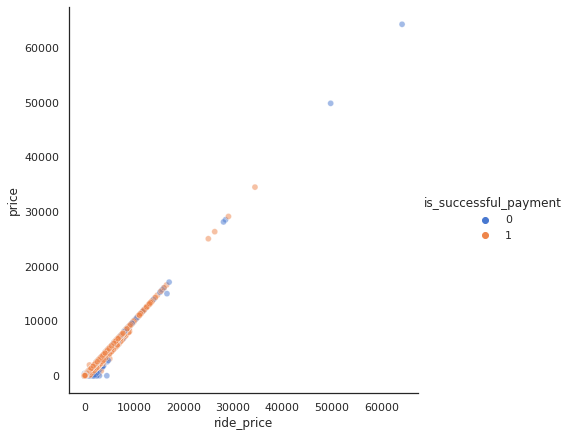

In [11]:
sns.set_theme(style="white")

sns.relplot(x="ride_price", y="price", hue="is_successful_payment",
            sizes=(400, 400), alpha=.5, palette="muted",
            height=6, data=df_price)

In [12]:
df_price['flag_price_0'] = df_price.apply(lambda x:1 if x['price'] == 0 else(0),axis=1)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [13]:
df_price.sample(5)

,price,ride_price,is_successful_payment,flag_price_0
159060,0.0,0.0,0,1
247192,3.4,3.4,1,0
46244,0.0,190.0,0,1
289876,170.0,170.0,1,0
50378,0.0,125.0,0,1


In [14]:
df_price=df_price[['flag_price_0','is_successful_payment','price']]

In [15]:
table = pd.pivot_table(df_price, values='price', index=['is_successful_payment'],
                    columns=['flag_price_0'], aggfunc='count', fill_value=0)

In [16]:
table.head()

flag_price_0,0,1
is_successful_payment,,
0,17090,61943
1,225020,0


<AxesSubplot:title={'center':'Price 0'}, xlabel='is_successful_payment', ylabel='Price Segment'>

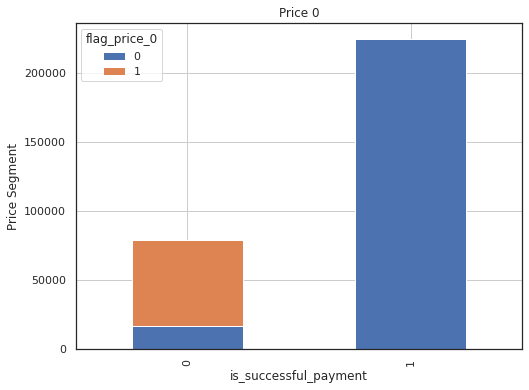

In [17]:
table.plot(kind='bar',
        title = 'Price 0',
        ylabel = 'Price Segment',
        figsize = (8,6),
        grid = True,
        stacked = True)

We can see that all the transactions with flag_price_0 == 1 (orange) are non successful payment transactions.
If we block all transactions with price = 0 we are just blocking non successful payment transactions causing no friction at all on the healthy ones

This rule will have a recall of 78.4% with a precision of 100% and a friction of 0%

## Filter TRXs with price = 0

From now on we take out of consideration TRXs with price == 0 because dose TRXs will be blocked by the previous rule 

In [18]:
df_1 = df[df['price']!=0]

In [19]:
df_1.sample(3)

,created,device_name,device_os_version,country,city_id,lat,lng,real_destination_lat,real_destination_lng,user_id,...,distance,ride_distance,price,ride_price,price_review_status,price_review_reason,is_successful_payment,name,card_bin,failed_attempts
269895,2017-02-25 07:04:30,samsungSM-N9005,samsung5.0,za,242.0,-29.845835,31.034272,-29.860585,31.025269,1074692,...,2164,2981,30.0000,30.0000,ok,NaN,1,**** 8929,479012.0,1
224653,2017-07-16 15:21:46,XiaomiRedmi 3,Xiaomi5.1.1,lt,13.0,54.856707,23.942354,54.896090,23.932974,809942,...,3842,7559,4.2999,4.2999,ok,NaN,1,**** 9620,516889.0,0
45918,2016-07-22 20:10:27,OnePlusONEPLUS A3010,OnePlus7.1.1,lv,3.0,56.950051,24.111160,56.983687,24.197512,633538,...,559,8320,5.9000,5.9000,ok,NaN,1,**** 9131,557367.0,1


## Attempts Analys

In [20]:
df_att = df_1[['order_id','failed_attempts','is_successful_payment']]

In [21]:
df_att.sample(5)

,order_id,failed_attempts,is_successful_payment
237452,18894833,0,1
14585,20820434,0,1
204529,12536102,0,1
23951,12334322,0,1
241825,5427095,0,1


In [22]:
table = pd.pivot_table(df_att, values='order_id', index=['failed_attempts'],
                    columns=['is_successful_payment'], aggfunc='count', fill_value=0)

In [23]:
table.head(3)

is_successful_payment,0,1
failed_attempts,,
0,11303,181174
1,2943,29788
2,1156,8103


<AxesSubplot:title={'center':'Failed Attempts'}, xlabel='failed_attempts', ylabel='TRX'>

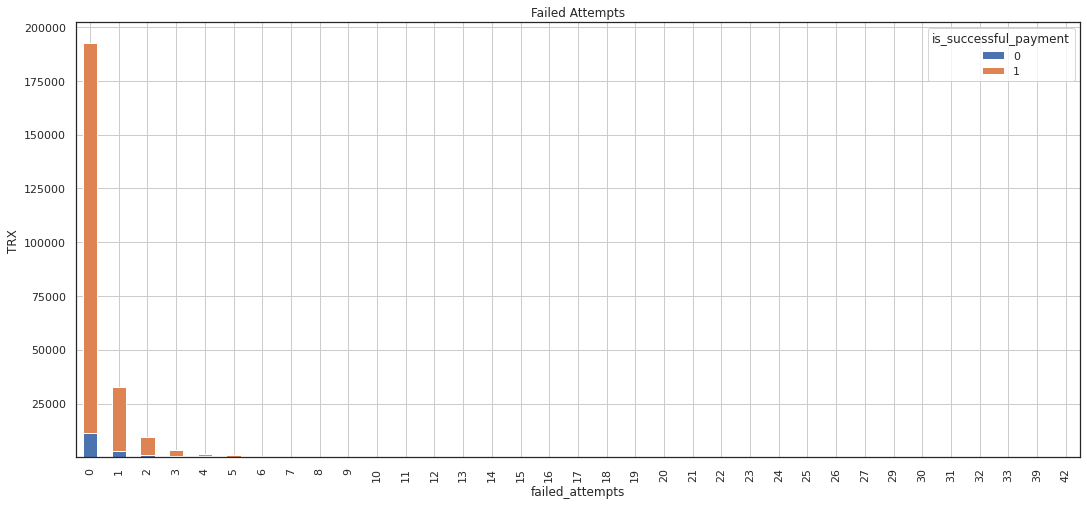

In [24]:
table.plot(kind='bar',
        title = 'Failed Attempts',
        ylabel = 'TRX',
        figsize = (18,8),
        grid = True,
        stacked = True)

In [25]:
gb1=df_att.groupby(['failed_attempts','is_successful_payment']).count()
gb1=gb1.reset_index()

gb2=gb1[['failed_attempts','order_id']].groupby(['failed_attempts']).sum()
gb2=gb2.reset_index()
gb2['TOTAL']=gb2['order_id']
gb2=gb2[['failed_attempts','TOTAL']]

gb3 = pd.merge(left = gb1, right = gb2,
                how = 'inner',
                left_on='failed_attempts', right_on='failed_attempts')

gb3['share']=(gb3['order_id']/gb3['TOTAL'])*100
gb3['share']=gb3['share'].round(decimals=1)

gb3 = gb3[gb3['is_successful_payment']==0]

In [26]:
gb3.sort_values('failed_attempts',ascending=True).head(15)

,failed_attempts,is_successful_payment,order_id,TOTAL,share
0,0,0,11303,192477,5.9
2,1,0,2943,32731,9.0
4,2,0,1156,9259,12.5
6,3,0,590,3547,16.6
8,4,0,374,1687,22.2
10,5,0,216,866,24.9
12,6,0,140,549,25.5
14,7,0,103,311,33.1
16,8,0,66,202,32.7
18,9,0,45,122,36.9


In [27]:
def group_failed_attempts():
    
    values_list = [0, 2, 4, 6, 10, 20, 999999]

    conditions_att = []

    for i in values_list:
        if i == 0:
            condicion = ((df_att['failed_attempts'].fillna(0)) == 0)
            conditions_att.append(condicion)
        else:
            condicion = ((df_att['failed_attempts'].fillna(0)) <= i)
            conditions_att.append(condicion)

    df_att['failed_attempts_range'] = np.select(conditions_att, values_list)
    
group_failed_attempts()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
df_att.sample(3)

,order_id,failed_attempts,is_successful_payment,failed_attempts_range
162912,21428659,0,1,0
136329,16347170,0,1,0
141156,23111519,0,0,0


In [29]:
df_att.drop(columns=['failed_attempts'], inplace=True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [30]:
table = pd.pivot_table(df_att, values='order_id', index=['failed_attempts_range'],
                    columns=['is_successful_payment'], aggfunc='count', fill_value=0)

<AxesSubplot:title={'center':'Failed Attempts'}, xlabel='failed_attempts_range', ylabel='TRX'>

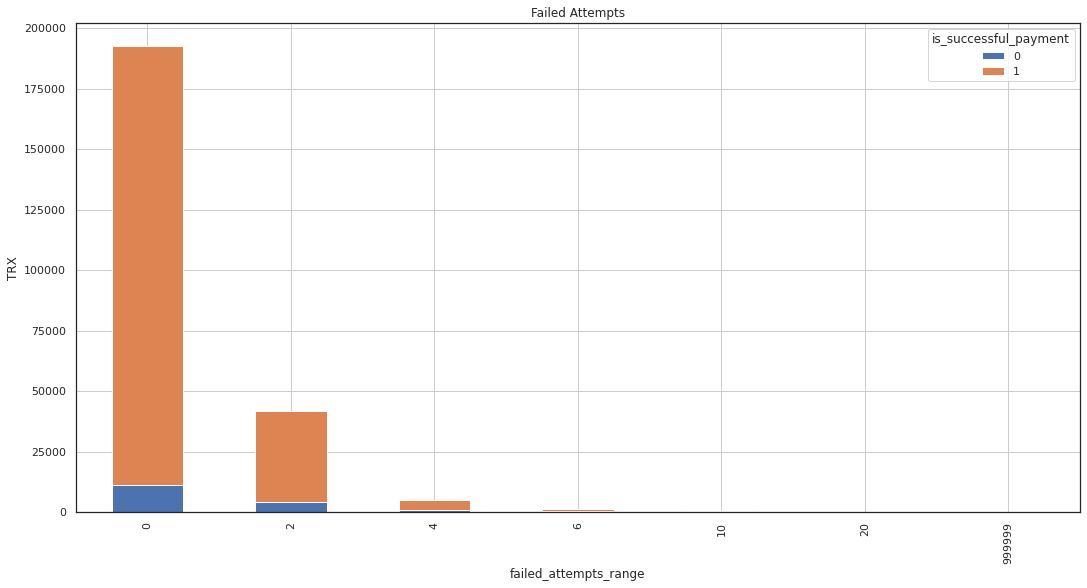

In [31]:
table.plot(kind='bar',
        title = 'Failed Attempts',
        ylabel = 'TRX',
        figsize = (18,9),
        grid = True,
        stacked = True)

In [32]:
gb1=df_att.groupby(['failed_attempts_range','is_successful_payment']).count()
gb1=gb1.reset_index()

gb2=gb1[['failed_attempts_range','order_id']].groupby(['failed_attempts_range']).sum()
gb2=gb2.reset_index()
gb2['TOTAL']=gb2['order_id']
gb2=gb2[['failed_attempts_range','TOTAL']]

gb3 = pd.merge(left = gb1, right = gb2,
                how = 'inner',
                left_on='failed_attempts_range', right_on='failed_attempts_range')

gb3['share']=(gb3['order_id']/gb3['TOTAL'])*100
gb3['share']=gb3['share'].round(decimals=1)

gb3 = gb3[gb3['is_successful_payment']==0]

In [33]:
gb3.sort_values('failed_attempts_range',ascending=True).head(7)

,failed_attempts_range,is_successful_payment,order_id,TOTAL,share
0,0,0,11303,192477,5.9
2,2,0,4099,41990,9.8
4,4,0,964,5234,18.4
6,6,0,356,1415,25.2
8,10,0,249,722,34.5
10,20,0,107,248,43.1
12,999999,0,12,24,50.0


There is a non successful rate over 30% on TRXs that had 7 or more attempts. We can block these TRXs with a velocity rule that counts the total attempts.

This rule will have a recall of 3.4% with a precision of 35.7%

## Filter TRXs with 7 or more attempts

From now on we take out of consideration TRXs with 7 or more attempts because dose TRXs will be blocked by the previous rule 

In [34]:
df_2 = df_1[df_1['failed_attempts']<7]

In [35]:
df_2.sample(3)

,created,device_name,device_os_version,country,city_id,lat,lng,real_destination_lat,real_destination_lng,user_id,...,distance,ride_distance,price,ride_price,price_review_status,price_review_reason,is_successful_payment,name,card_bin,failed_attempts
165637,2016-12-10 07:24:04,iPhone7,iOS10.3.2,za,54.0,-26.144673,28.043120,-26.194158,28.034876,946079,...,260,6879,70.0000,70.0000,ok,NaN,1,**** 9281,484162.0,0
151876,2017-07-17 10:53:31,samsungSM-J710F,samsung6.0.1,ee,1.0,59.432887,24.765726,59.424919,24.701021,2115084,...,2578,4792,3.7999,3.7999,ok,NaN,1,**** 3773,516737.0,0
288660,2017-01-26 06:51:54,unknownWAS-LX1,unknown7.0,za,54.0,-26.251556,28.046879,-26.244721,28.024533,799356,...,646,3099,35.0000,35.0000,ok,NaN,1,**** 7288,412752.0,0


## BIN Analys

In [36]:
df_bin = df_2[['order_id','card_bin','is_successful_payment']]

In [37]:
df_bin.sample(3)

,order_id,card_bin,is_successful_payment
48195,6669601,479695.0,1
292395,25356268,492305.0,1
180034,22909542,522126.0,1


In [38]:
df_bin['card_bin'] = df_bin['card_bin'].fillna(0)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [39]:
gb1=df_bin.groupby(['card_bin','is_successful_payment']).count()
gb1=gb1.reset_index()

gb2=gb1[['card_bin','order_id']].groupby(['card_bin']).sum()
gb2=gb2.reset_index()
gb2['TOTAL']=gb2['order_id']
gb2=gb2[['card_bin','TOTAL']]

gb3 = pd.merge(left = gb1, right = gb2,
                how = 'inner',
                left_on='card_bin', right_on='card_bin')

gb3['share']=(gb3['order_id']/gb3['TOTAL'])*100
gb3['share']=gb3['share'].round(decimals=1)

gb3 = gb3[gb3['is_successful_payment']==0]


In [40]:
gb3.sort_values('order_id',ascending=False).head(25)

,card_bin,is_successful_payment,order_id,TOTAL,share
6880,528497.0,0,2143,7734,27.7
4988,484162.0,0,505,6455,7.8
0,0.0,0,403,3756,10.7
6030,516875.0,0,375,934,40.1
5253,491566.0,0,369,502,73.5
1620,412752.0,0,321,7671,4.2
4329,466544.0,0,266,312,85.3
8886,557368.0,0,223,6762,3.3
1618,412722.0,0,218,1056,20.6
5638,510621.0,0,207,236,87.7


We can blacklist BINs that seams to be dirty BINs and have a considerate amount of non succesful TRXs

BINs to blacklist: [491566.0, 466544.0, 510621.0, 518759.0, 522772.0, 551238.0, 548822.0]

 This will have a recall of 8.4% with a precision of 83.7%

## Conclutions

1- We can set a rule of price where all TRXs that are with price = 0 will be blocked.
This rule will have a recall of 78.4% with a precision of 100% and causing non friction at all

2- Implementing a velocity count rule where we count the number of attempts in a TRX, with 7 or more attempts, the TRX will be blocked. This rule will have a recall of 3.4% with a precision of 35.7%

3- Also, we can send to blacklist a given number of BINs. If we blacklist this list of 7 BINs we would have a recall of 8.4% on non successful TRXs with a precision of 83.7%

With all these implementations we are going to reduce the non succesful TRXs from 79033 to 15322. That is a reduction of an 80.6% on these TRX